# [오피니언 라이브 언어모델 세미나 실습]
## BERT를 이용한 소비자 리뷰 긍/부정 감성분류



## 실습 요약

1. 본 실습에서는 사전 학습된 BERT를 활용하여 감성분석 모델을 구축합니다
2. 학습된 모델을 활용하여 평가를 진행합니다.


------

### STEP 0. 환경 구축하기
* 필요한 library들을 import 합니다

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import warnings
warnings.filterwarnings( 'ignore' )

# GPU Setting
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.chdir(os.getcwd())
print(f"현재 위치: {os.getcwd()}")

현재 위치: /home/doyoon/teaching/NLP-example


In [3]:
import sys
import json
import random
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
#%matplotlib inline #생성한 figure를 notebook에서 볼 수있게 해주는 코드

import gensim
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#check torch version & device
print ("Python version:[%s]."%(sys.version))
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device)) # device에 cuda:0가 프린트 된다면 GPU를 사용하는 상태입니다

Python version:[3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0]].
PyTorch version:[1.12.0+cu102].
device:[cuda:0].


In [4]:
! pip install transformers

In [5]:
# set random seed 

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

### STEP 1. 데이터 준비하기
금일 실습에서는 **Naver_shopping**에서 수집된 **리뷰 데이터**를 활용합니다.
* 제품별 후기를 별점과 함께 수집한 데이터
* 데이터셋 출처

  * 1) https://github.com/songys/AwesomeKorean_Data
  * 2) https://github.com/bab2min/corpus/tree/master/sentiment


* 해당 실습에서는 전체 데이터 중 50%인 10만개의 데이터를 사용함 (긍정 : 50000개, 부정 : 50000개)





In [6]:
# 데이터 불러오기
with open('./data/naver_shopping.txt','r',encoding='utf-8') as f:
  data = f.readlines()

In [7]:
# 분석에 사용할 형태로 가공하기
rate = []
label = []
sentence = []
for cur_review in tqdm(data):
  # 평점과 리뷰 문장 분리
  cur_review = cur_review.split('\t')
  # 평점
  rate.append(cur_review[0])
  # 리뷰 문장
  sentence.append(cur_review[1].strip('\n'))
  # 평점 4,5 : Positive, 
  # 평점 1,2 : Negative
  if int(cur_review[0]) >3:
    label.append(0) # positive
  else:
    label.append(1) # negative

100%|██████████| 200000/200000 [00:00<00:00, 776682.69it/s]


In [8]:
# 데이터 프레임 형태로 변환하기
df = {
    "rate" : rate,
    "label" : label,
    "sentence" : sentence
}
df = pd.DataFrame(df)
df = df.sample(frac=0.5,replace=False, random_state=42)

<Axes: >

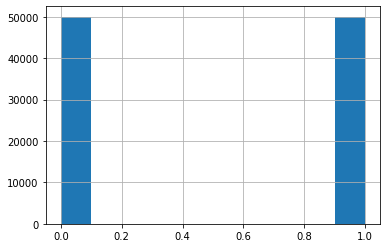

In [9]:
df['label'].hist()

In [10]:
df.head()

,rate,label,sentence
119737,2,1,마감이 안좋아요...실밥도 많고 바느질도 부족한 부분이 몇군데 있네요...교환받기 ...
72272,5,0,깨끗하게 잘 다듬어져 있어요. 맛도좋고요.
158154,4,0,재구매 배송빨라요 길냥이들이 잘먹어요~~ 대용량이라 좋네요~
65426,5,0,제품도 빨리 배송해주시고 꼼꼼하게 잘챙겨주셨어요
30074,5,0,기타 남 멋지고 예뻐요 여러 사은품도 좋아요


### STEP 2. 전처리 진행 (Preprocessing)

In [11]:
review_sentences = df['sentence'].to_list()
review_sentences[:10]

['마감이 안좋아요...실밥도 많고 바느질도 부족한 부분이 몇군데 있네요...교환받기 귀찮아서 그냥 씁니다',
 '깨끗하게 잘 다듬어져 있어요. 맛도좋고요.',
 '재구매 배송빨라요 길냥이들이 잘먹어요~~ 대용량이라 좋네요~',
 '제품도 빨리 배송해주시고 꼼꼼하게 잘챙겨주셨어요',
 '기타 남 멋지고 예뻐요 여러 사은품도 좋아요',
 '기존것보다 다리를 올려놓으면 푹빠지니깐 무서워서 안올라가요.ㅠㅠ 안고 올려놓으면 가만히 있는데. 습관되면 괜찮아지겠죠.^^',
 '상품은잘받았습니다 요청한거와 손잡이방향은다르게왔지만 설치는 잘했습니다. 좀더 신경을 써주시는게 어떨까 싶네요',
 '재구매 아기땜에 하루빨리 필요했는데 배송도 오래 걸렸는데 벨크로가 안왔어요 민원처리도 답답하구요 서비스 엉망입니다',
 '좋네요. 사서 방전된 차에 점프 했는데 잘 됐습니다.',
 '저렴하게 잘샀어요ㅎ 쓰던거라 좋아요']

In [12]:
import re
def preprocess(text):
  text = re.sub('[-=+,#/\?:^$~@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', text) # 특수문자 제거
  text = re.sub('[ㅠㅎㅋ]','', text) # 문자에서 많이 사용하는 ㅠ,ㅎ,ㅋ 남김
  return text

In [13]:
normalize_sentence = []
for sentence in tqdm(review_sentences):
  sentence = preprocess(sentence)
  normalize_sentence.append(sentence)

df['normalize_sentence'] = normalize_sentence

100%|██████████| 100000/100000 [00:00<00:00, 266868.23it/s]


### STEP 3. 토큰화 진행 (Tokenization)

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

tokenized_sentence = []
for sent in tqdm(normalize_sentence):
  sent = tokenizer.tokenize(sent)
  tokenized_sentence.append(sent) 

100%|██████████| 100000/100000 [00:09<00:00, 10834.58it/s]


In [15]:
df['tokenized_sentence'] = tokenized_sentence

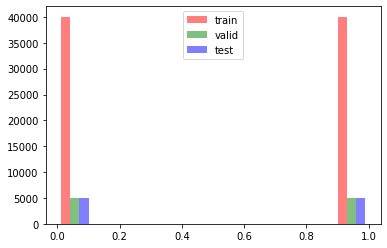

In [16]:
from sklearn.model_selection import train_test_split

# Train:Valid:Test = 8:1:1
train_df, test_df = train_test_split(df, test_size =0.2, random_state= 42)
valid_df, test_df = train_test_split(test_df, test_size =0.5, random_state= 42)

bins = np.linspace(0, 1, 10)
plt.hist([train_df['label'],valid_df['label'],test_df['label']],bins=bins,color=['r','g','b'],alpha=0.5,label=['train','valid','test'])
plt.legend(loc='upper center')
plt.show()

### STEP 4. 벡터화 진행 (Vectorization)
* 해당 실습에서는 모델 내부에서 벡터화를 진행합니다
  

### STEP 5. Dataset 구축하기

In [17]:
from torch.utils.data import Dataset, DataLoader

class BERTDataset(Dataset):
  def __init__(self, df, tokenizer, max_seq_length=100):
    self.max_seq_length = max_seq_length
    self.tokenizer = tokenizer
    self.df = df
    self.inputs = df["normalize_sentence"].to_list() # input sentence는 input 혹은 source라는 단어로 표현됨
    self.targets = df["label"].to_list() # output label은 target으로 표현됨

    self.vocab = self.tokenizer.vocab
    self.pad_idx = self.vocab['[PAD]']
    self.cls_idx = self.vocab['[CLS]']
    self.sep_idx = self.vocab['[SEP]']
    self.mask_idx = self.vocab['[MASK]']

  def convert_inputs_to_feature(self, input):
    # STEP 1 : word to index
    # 문장을 token 단위로 분리한 후, 모델이 이해할 수 있는 형태인 숫자로 바꾸어줍니다

    tokenized_input = self.tokenizer.encode(input)


    # STEP 2 : pad or truncate token
    # max length에 따라 input 문장의 길이 조절하여 동일한 길이의 input으로 변환
    # batch단위로 학습을 하기위해 다음과 같은 과정을 거침
    diff = self.max_seq_length - len(tokenized_input)
    if diff > 0:
      tokenized_input += [self.pad_idx] * diff 
    else:
      tokenized_input = tokenized_input[:self.max_seq_length-1] + [self.sep_idx]
    
    return tokenized_input

  def idx2mask(self, token_ids):
    # output bool; attention mask 생성
    return [token_id != self.pad_idx for token_id in token_ids]

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    input = self.inputs[idx]
    target = self.targets[idx]

    tokenized_input = self.convert_inputs_to_feature(input)
    att_mask = self.idx2mask(tokenized_input)

    # print(len(tokenized_input))
    # print(self.max_seq_length)

    # tokenized input이 max_seq_length와 같은지 무조건 체크
    # att_mask가 max_seq_length와 같은지 무조건 체크
    assert len(tokenized_input) == self.max_seq_length
    assert len(att_mask) == self.max_seq_length

    batch = [
            torch.tensor(tokenized_input),
            torch.tensor(att_mask),
            torch.tensor(target),
    ]
    return batch

In [18]:
BATCH_SIZE = 50

train_dataset = BERTDataset(
    df = train_df,
    tokenizer = tokenizer,
    max_seq_length=30)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle=True,
    )

valid_dataset = BERTDataset(
    df = valid_df,
    tokenizer = tokenizer,
    max_seq_length=30)

valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE,
    shuffle=False,
    )

In [19]:
from transformers import BertForSequenceClassification , AdamW
from torch.nn import CrossEntropyLoss
# Huggingface에서 모델 불러오기
model = BertForSequenceClassification.from_pretrained('klue/bert-base') #klue 데이터로 사전학습 된 체크포인트
model = model.to(device)

# 모델 내 parameter 업데이트를 위한 함수
LR = 1e-5
optimizer = AdamW(model.parameters(), lr=LR)

# Loss 함수 구하기
criterion = CrossEntropyLoss()

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

### 학습 Hyperparameter 설정
  (1) Epoch 수  
  (2) Validation 실시 조건: 몇 번의 batch마다 검증을 할 것인가  
  (3) accumulation step 이용: 몇 개의 batch 마다 loss에 대해 업데이트 할 것인가

### (1) Epoch ver

In [20]:
from sklearn.metrics import f1_score, accuracy_score

def convert_device(device,*args):
  return [arg.to(device) for arg in args]

def get_scores(targets,logit):
  preds = torch.argmax(F.softmax(logit),dim=1).cpu().detach().numpy()
  targets = targets.cpu().detach().numpy()
  acc = accuracy_score(targets,preds)
  f1 = f1_score(targets, preds, average = 'macro')
  return acc, f1

def get_mean_scores(*args):
  return [np.mean(arg) for arg in args]


  
# train
EPOCH = 5
LOG_INTERVAL = int(len(train_loader)*0.05) # 총 trainset의 batch 개수의 10% 씩 학습이 이루어진 후 검증 진행
model.train()

savedir = os.path.join('/content/results/','Epoch_ver')
os.makedirs(savedir, exist_ok=True)


train_loss, train_acc, train_f1 = [],[],[]
valid_loss, valid_acc, valid_f1 = [],[],[]

best_acc = 0

for epoch in range(EPOCH):
    train_batch_loss_list, train_batch_acc_list, train_batch_f1_list = [],[],[]    
    for step, batch in enumerate(train_loader):
        inputs, att_mask, targets = batch

        inputs = inputs.to(device)
        att_mask = att_mask.to(device)
        targets = targets.to(device)

        model.zero_grad()
        outputs = model(inputs, attention_mask=att_mask, labels=targets)
        
        train_batch_loss = outputs[0]
        train_batch_logit = outputs[1]
        
        # loss
        train_batch_loss_list.append(train_batch_loss.item())
        train_batch_loss.backward()
        
        # scores
        train_batch_acc, train_batch_f1 = get_scores(targets,train_batch_logit)
        train_batch_acc_list.append(train_batch_acc)
        train_batch_f1_list.append(train_batch_f1)

        optimizer.step()
        optimizer.zero_grad()
        if (step+1) % LOG_INTERVAL == 0:
            print('Train | [%d/%d] [%d/%d] | loss: %f | Acc: %f | F1: %f' % (epoch+1, EPOCH, step, len(train_loader), train_batch_loss.item(),train_batch_acc, train_batch_f1))

    train_epoch_loss, train_epoch_acc, train_epoch_f1 = get_mean_scores(*[train_batch_loss_list,train_batch_acc_list,train_batch_f1_list])
    
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    train_f1.append(train_epoch_f1)
    
    # evaluate  
    valid_batch_loss_list, valid_batch_acc_list, valid_batch_f1_list = [],[],[]  
    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(valid_loader):
            inputs, att_mask, targets = convert_device(device,*batch)
            outputs = model(inputs, attention_mask=att_mask, labels=targets)

            valid_batch_loss = outputs[0].item()
            valid_logit = outputs[1]

            valid_batch_acc, valid_batch_f1 = get_scores(targets,valid_logit)
            
            valid_batch_loss_list.append(valid_batch_loss)
            valid_batch_acc_list.append(valid_batch_acc)
            valid_batch_f1_list.append(valid_batch_f1)
    
    valid_epoch_loss, valid_epoch_acc, valid_epoch_f1 = get_mean_scores(*[valid_batch_loss_list,valid_batch_acc_list,valid_batch_f1_list])
    print('Valid | [%d/%d] | loss: %f | Acc: %f | F1: %f' % (epoch+1, EPOCH, valid_epoch_loss, valid_epoch_acc, valid_epoch_f1))

    valid_loss.append(valid_epoch_loss)
    valid_acc.append(valid_epoch_acc)
    valid_f1.append(valid_epoch_f1)
    
    # checkpoint
    if best_acc < valid_epoch_acc:
        # save best score
        state = {'best_step':epoch}
        state.update({'best_acc':valid_epoch_acc,'best_f1':valid_epoch_f1})

        # save best model
        torch.save(model.state_dict(), os.path.join(savedir, f'best_model.pt'))
        
        print('Best Accuracy {0:.3%} to {1:.3%}'.format(best_acc, valid_epoch_acc))

        best_acc = valid_epoch_acc

    

Train | [1/5] [79/1600] | loss: 0.283583 | Acc: 0.900000 | F1: 0.894914
Train | [1/5] [159/1600] | loss: 0.311968 | Acc: 0.900000 | F1: 0.899960
Train | [1/5] [239/1600] | loss: 0.196806 | Acc: 0.940000 | F1: 0.936948
Train | [1/5] [319/1600] | loss: 0.331560 | Acc: 0.880000 | F1: 0.879227
Train | [1/5] [399/1600] | loss: 0.204433 | Acc: 0.960000 | F1: 0.960000
Train | [1/5] [479/1600] | loss: 0.190118 | Acc: 0.940000 | F1: 0.936948
Train | [1/5] [559/1600] | loss: 0.256224 | Acc: 0.900000 | F1: 0.896652
Train | [1/5] [639/1600] | loss: 0.229275 | Acc: 0.920000 | F1: 0.913194
Train | [1/5] [719/1600] | loss: 0.294918 | Acc: 0.880000 | F1: 0.879808
Train | [1/5] [799/1600] | loss: 0.154131 | Acc: 0.940000 | F1: 0.939783
Train | [1/5] [879/1600] | loss: 0.114171 | Acc: 0.980000 | F1: 0.979992
Train | [1/5] [959/1600] | loss: 0.162619 | Acc: 0.900000 | F1: 0.899639
Train | [1/5] [1039/1600] | loss: 0.374205 | Acc: 0.860000 | F1: 0.859494
Train | [1/5] [1119/1600] | loss: 0.186999 | Acc: 0

<Axes: >

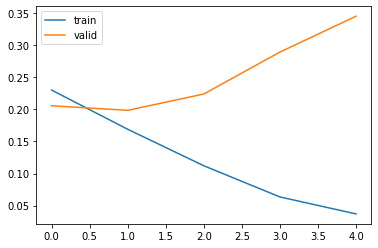

In [21]:
LOSS_RESULTS={'train':train_loss,'valid':valid_loss}
ACC_RESULTS={'train':train_acc,'valid':valid_acc}
F1_RESULTS={'train':train_f1,'valid':valid_f1}

pd.DataFrame(LOSS_RESULTS).plot(title='Loss')
pd.DataFrame(ACC_RESULTS).plot(title='Accuracy')
pd.DataFrame(F1_RESULTS).plot(title='F1 Score')

### 학습 완료된 모델 시험하기

In [22]:
# 시험용 데이터셋 구축

test_dataset = BERTDataset(
    df = test_df,
    tokenizer = tokenizer,
    max_seq_length=30)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle=False,
    )

In [23]:
model.eval()

model_prediction = []
test_label = []
with torch.no_grad():
    for step, batch in enumerate(test_loader):
        inputs, att_mask, targets = batch

        inputs = inputs.to(device)
        att_mask = att_mask.to(device)
        targets = targets.to(device)

        outputs = model(inputs, attention_mask=att_mask, labels=targets)
        
        logit = outputs[1]

        preds = torch.argmax(F.softmax(logit),dim=1)
        preds = preds.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()

        model_prediction.extend(preds)
        test_label.extend(targets)
        assert len(model_prediction) == len(test_label)

In [24]:
from sklearn.metrics import f1_score, accuracy_score

# 성능 평가하기
print('Test data f1 score : ',f1_score(test_label, model_prediction, average='macro'))
print('Test data accuracy score : ',accuracy_score(test_label, model_prediction))

Test data f1 score :  0.9156868260665729
Test data accuracy score :  0.9157


### (2) 실험ver

In [25]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



import time
import json

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
import transformers


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



def training(model,
             num_training_steps: int,
             trainloader, 
             validloader,
             criterion,
             optimizer,
             log_interval: int, 
             eval_interval: int, 
             savedir: str, 
             accumulation_steps: int = 1, 
             device: str = 'cpu'):
  
    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    acc_m = AverageMeter()
    losses_m = AverageMeter()
    best_acc = 0
    
    end = time.time()
    
    model.train()
    optimizer.zero_grad()

    step = 0
    train_mode = True
    while train_mode:
        for batch in trainloader:
            # batch
            inputs, att_mask, targets = convert_device(device,*batch)
            data_time_m.update(time.time() - end)

            # optimizer condition
            opt_cond = (step + 1) % accumulation_steps == 0

            # predict
            outputs = model(inputs, attention_mask=att_mask, labels=targets)
            logit = outputs[1]
            loss = criterion(logit, targets)
            
            # loss for accumulation steps
            loss /= accumulation_steps        
            loss.backward()

            if opt_cond:
                # loss update
                optimizer.step()
                optimizer.zero_grad()

                losses_m.update(loss.item()*accumulation_steps)

                # accuracy
                preds = torch.argmax(F.softmax(logit),dim=1)
                acc_m.update(targets.eq(preds).sum().item()/targets.size(0), n=targets.size(0))
                
                batch_time_m.update(time.time() - end)
                
                if ((step+1) // accumulation_steps) % log_interval == 0 or step == 0:
                     
                    print('TRAIN | [{:>4d}/{}] Loss: {loss.val:>6.4f} ({loss.avg:>6.4f}) '
                                'Acc: {acc.avg:.3%} '
                                'LR: {lr:.3e} '
                                'Time: {batch_time.val:.3f}s ({batch_time.avg:.3f}) ' # {rate:>7.2f}/s ({batch_time.avg:.3f}s, {rate_avg:>7.2f}/s) '
                                'Data: {data_time.val:.3f} ({data_time.avg:.3f})'.format(
                                (step+1)//accumulation_steps, num_training_steps, 
                                loss       = losses_m, 
                                acc        = acc_m, 
                                lr         = optimizer.param_groups[0]['lr'],
                                batch_time = batch_time_m,
                                data_time  = data_time_m))


                if (((step+1) // accumulation_steps) % eval_interval == 0 and step != 0) or step+1 == num_training_steps: 
                    eval_metrics = evaluate(model, validloader, criterion, log_interval, device)
                    model.train()

                    eval_log = dict([(f'eval_{k}', v) for k, v in eval_metrics.items()])

                    # checkpoint
                    if best_acc < eval_metrics['acc']:
                        # save best score
                        state = {'best_step':step}
                        state.update(eval_log)
                        json.dump(state, open(os.path.join(savedir, 'best_score.json'),'w'), indent=4)

                        # save best model
                        torch.save(model.state_dict(), os.path.join(savedir, f'best_model.pt'))
                        
                        print('Best Accuracy {0:.3%} to {1:.3%}'.format(best_acc, eval_metrics['acc']))

                        best_acc = eval_metrics['acc']

            end = time.time()

            step += 1

            if (step // accumulation_steps) >= num_training_steps:
                train_mode = False
                break

    # save best model
    torch.save(model.state_dict(), os.path.join(savedir, f'latest_model.pt'))

    print('Best Metric: {0:.3%} (step {1:})'.format(best_acc, state['best_step']))
    
        
def evaluate(model, dataloader, criterion, log_interval: int, device: str = 'cpu', sample_check: bool = False):
    correct = 0
    total = 0
    total_loss = 0
    total_score = []
    total_preds = []
    total_targets = []

    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            inputs, att_mask, targets = convert_device(device,*batch)
            
            # predict
            outputs = model(inputs, attention_mask=att_mask, labels=targets)
            logit = outputs[1]

            # loss 
            loss = criterion(logit, targets)
            
            # total loss and acc
            total_loss += loss.item()
            preds = torch.argmax(F.softmax(logit),dim=1)

            correct += targets.eq(preds).sum().item()
            total += targets.size(0)

            total_score.extend(logit.cpu().tolist())
            total_preds.extend(preds.cpu().tolist())
            total_targets.extend(targets.cpu().tolist())
            
            if idx % log_interval == 0 and idx != 0: 
                print('Validation log | [%d/%d]: Loss: %.3f | Acc: %.3f%% [%d/%d]' % 
                            (idx+1, len(dataloader), total_loss/(idx+1), 100.*correct/total, correct, total))
            print()
                
    metrics = calc_metrics(
        y_true  = total_targets,
        y_score = np.array(total_score)[:,1],
        y_pred  = total_preds
    )
    
    metrics.update([('acc',correct/total), ('loss',total_loss/len(dataloader))])

    print('Validation | Loss: %.3f | Acc: %.3f%% | AUROC: %.3f%% | F1-Score: %.3f%%' % 
                (metrics['loss'], 100.*metrics['acc'], 100.*metrics['auroc'], 100.*metrics['f1']))

    if sample_check:
        results = {
            'targets': total_targets,
            'preds'  : total_preds,
            'outputs': total_score
        }
        return metrics, results
    else:
        return metrics


def calc_metrics(y_true: list, y_score: np.ndarray, y_pred: list) -> dict:
    auroc = roc_auc_score(y_true, y_score)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f'TN: {tn}, FP: {fp}, FN: {fn}, tp: {tp}')

    return {
        'auroc'    : auroc, 
        'f1'       : f1, 
    }


In [26]:
num_training_steps = len(train_loader)*5
log_interval = int(len(train_loader)*0.1)
eval_interval = int(len(train_loader)*0.1)

savedir = os.path.join('/content/results','Experiment_ver')
os.makedirs(savedir, exist_ok=True)
accumulation_steps = 1


training(
  model              = model,
  num_training_steps = num_training_steps,
  trainloader        = train_loader, 
  validloader        = valid_loader, 
  criterion          = criterion, 
  optimizer          = optimizer, 
  log_interval       = log_interval,
  eval_interval      = eval_interval,
  savedir            = savedir,
  accumulation_steps = accumulation_steps,
  device             = device,
        )

TRAIN | [   1/8000] Loss: 0.1014 (0.1014) Acc: 96.000% LR: 1.000e-05 Time: 0.166s (0.166) Data: 0.019 (0.019)
TRAIN | [ 160/8000] Loss: 0.0630 (0.0625) Acc: 97.588% LR: 1.000e-05 Time: 0.154s (0.156) Data: 0.005 (0.006)
































































































































































Validation log | [161/200]: Loss: 0.341 | Acc: 92.286% [7429/8050]








































TN: 4627, FP: 390, FN: 364, tp: 4619
Validation | Loss: 0.333 | Acc: 92.460% | AUROC: 96.639% | F1-Score: 92.454%
Best Accuracy 0.000% to 92.460%
TRAIN | [ 320/8000] Loss: 0.0312 (0.0640) Acc: 97.500% LR: 1.000e-05 Time: 0.159s (0.157) Data: 0.005 (0.006)
































































































































































Validation log | [161/200]: Loss: 0.334 | Acc: 92.012% [7407/8050]
































#### 학습 완료된 모델 시험하기

In [27]:
# 시험용 데이터셋 구축

test_dataset = BERTDataset(
    df = test_df,
    tokenizer = tokenizer,
    max_seq_length=30)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle=False,
    )

In [28]:
# Test
num_test_steps = len(test_loader)
log_interval = int(num_test_steps*0.1)
eval_interval = int(num_test_steps*0.1)
metrics, exp_results = evaluate(
                    model        = model, 
                    dataloader   = test_loader, 
                    criterion    = criterion,
                    log_interval = log_interval,
                    device       = device,
                    sample_check = True
                )
                
# save result metrics
json.dump(metrics, open("test_results.json",'w'), indent='\t')





















Validation log | [21/200]: Loss: 0.407 | Acc: 91.429% [960/1050]




















Validation log | [41/200]: Loss: 0.417 | Acc: 91.756% [1881/2050]




















Validation log | [61/200]: Loss: 0.449 | Acc: 91.213% [2782/3050]




















Validation log | [81/200]: Loss: 0.438 | Acc: 91.309% [3698/4050]




















Validation log | [101/200]: Loss: 0.422 | Acc: 91.545% [4623/5050]




















Validation log | [121/200]: Loss: 0.417 | Acc: 91.669% [5546/6050]




















Validation log | [141/200]: Loss: 0.420 | Acc: 91.730% [6467/7050]




















Validation log | [161/200]: Loss: 0.410 | Acc: 91.764% [7387/8050]




















Validation log | [181/200]: Loss: 0.408 | Acc: 91.812% [8309/9050]




















TN: 4523, FP: 412, FN: 405, tp: 4660
Validation | Loss: 0.405 | Acc: 91.830% | AUROC: 96.769% | F1-Score: 91.940%


Credits: Lee Yukyung, Doyoon Kim